[View in Colaboratory](https://colab.research.google.com/github/DongminWu/MLpractice/blob/master/seq2seq_autoencoder.ipynb)

# Seq2seq testing

The main purpose is to try about the Seq2Seq LSTM neural network, to see if it can be used for feature extraction of time series data.

The structure and explaination of Seq2Seq neural network is [here](https://guillaumegenthial.github.io/sequence-to-sequence.html)

In this notebook, I will just try the vanilla Seq2Seq with some atificial data.


## Structure of 'this' Vanilla Seq2Seq 


- Input Data: Time series, binary data. The density of the data varies amongst time.
- Goal: Makeing the Neural Network learn the hidden pattern inside the time series, by using the values of the latent layer(extracted features), we can easily clustering the data.



# Libraries

In [2]:

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from scipy.stats import norm

from scipy.signal import triang

# Faking some data

1. Gaussian distributions, different mean and different variance
2. Triangle waves, with different sequence

All the data will contain 10% of random probabilities.

## Probability density funcitons

In [0]:
day_length = 1440

In [0]:
def gaussian_pdf(mu,  sigma, length):
  '''
  mu: mean of the gaussian distribution
  sigma: variance of the gaussian distribution
  
  length: the length of the sequence
  '''
  
  raw_ = np.linspace(-5, 5, length)
  ret = 1/(sigma * np.sqrt(2 * np.pi)) * \
      np.exp( - (raw_ - mu)**2 / (2 * sigma**2))
  return ret
                     

143.8999189797876

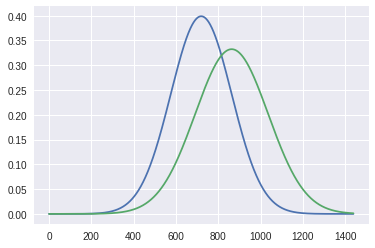

In [6]:
g1 = gaussian_pdf(0, 1, day_length)
g2 = gaussian_pdf(1, 1.2, day_length)

plt.plot(g1)
plt.plot(g2)


g1.sum()

288.0

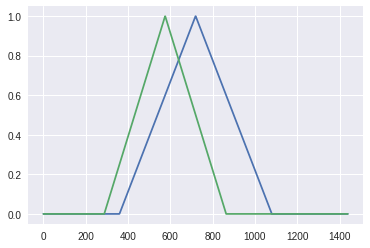

In [7]:
# Triangle wave

def triangle_pdf(mid, width, length):

  raw_ = np.linspace(-5, 5, length)

  l_mask = mid  - float(width)/2
  l_empty = np.where(raw_ < l_mask)[0]

  ret_l = [0]*len(l_empty)

  r_mask = mid + float(width)/2
  r_empty = np.where(raw_ > r_mask)[0]
  ret_r = [0]*len(r_empty)

  number_mid = length - len(l_empty) - len(r_empty)
  ret_m = triang(number_mid)

  ret = np.concatenate([ret_l, ret_m, ret_r])
  
#   h = 2. / width
  
  ret = ret
  
  return ret

t1 = triangle_pdf(0,5, day_length)
t2 = triangle_pdf(-1,4, day_length)



plt.plot(t1)
plt.plot(t2)


t2.sum()

In [0]:
# def rectangle_pdf()

In [0]:
def random_pdf(prob, max, length):
  raw = [0] * length
  
  for i,each in enumerate(raw):
    r = np.random.random()
    if r < prob:
      raw[i] = np.random.uniform(-max, max)

  return np.array(raw)

r1 = random_pdf(0.1, 0.2, day_length)


In [0]:
def generate_binary(distribution):
  return np.array([np.random.choice( np.array([0,1]),p=[1-p,p]) for p in distribution])

## Generating fake data 

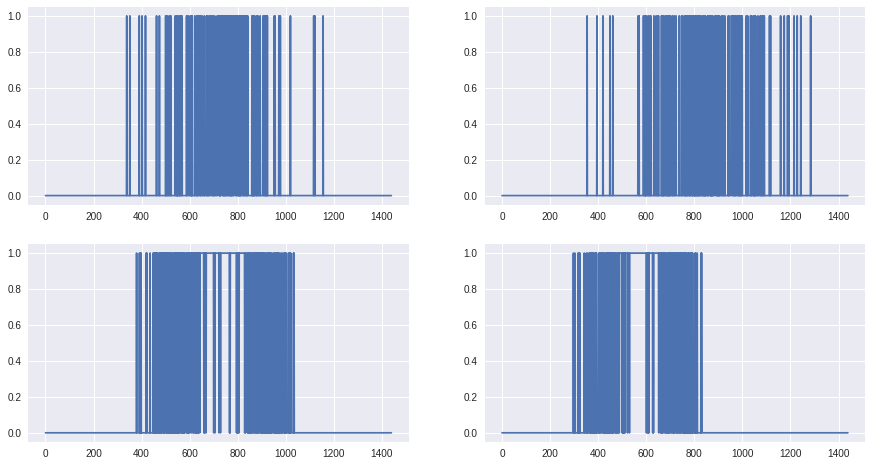

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f104a2e5490>,
      dtype=object)

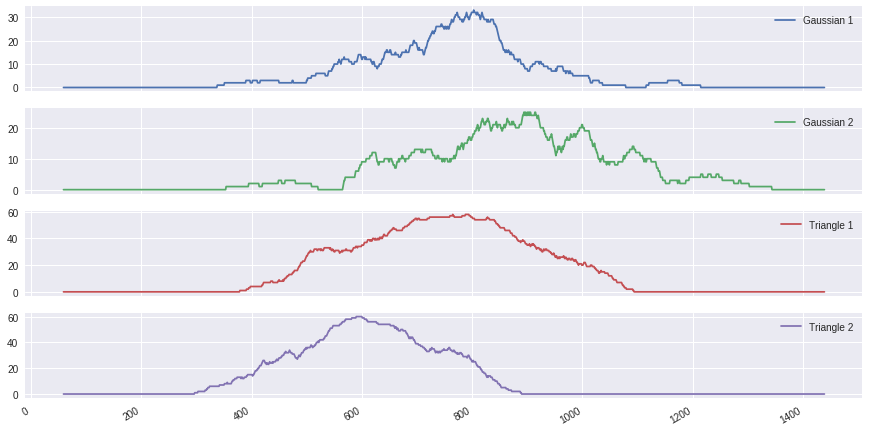

In [10]:

gr1 = np.clip(g1 + r1, 0, 1)
gr2 = np.clip(g2 + r1, 0, 1)
tr1 = np.clip(t1 + r1, 0, 1)
tr2 = np.clip(t2 + r1, 0, 1)

gr1 = g1
gr2 = g2
tr1 = t1
tr2 = t2




d_g1 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in gr1]
d_g2 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in gr2]
d_t1 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in tr1]
d_t2 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in tr2]


plt.figure(figsize=(15,8))


plt.subplot(2,2,1)
plt.plot(d_g1)

plt.subplot(2,2,2)
plt.plot(d_g2)

plt.subplot(2,2,3)
plt.plot(d_t1)

plt.subplot(2,2,4)
plt.plot(d_t2)

plt.show()


data_sample = pd.DataFrame()

data_sample['Gaussian 1'] = d_g1
data_sample['Gaussian 2'] = d_g2


data_sample['Triangle 1'] = d_t1
data_sample['Triangle 2'] = d_t2


data_sample.rolling(60).sum() \
        .plot(subplots=True, figsize=(15,8))


In [17]:
num_of_each_type = 18
num_of_weekend = 13

# 4 sensors

g1_set = [generate_binary(gaussian_pdf(0,1,day_length)) for i in range(num_of_each_type)]
g2_set = [generate_binary(gaussian_pdf(1,1.3,day_length)) for i in range(num_of_each_type)]
t1_set = [generate_binary(triangle_pdf(0,5,day_length)) for i in range(num_of_each_type)]
t2_set = [generate_binary(triangle_pdf(-1,4,day_length)) for i in range(num_of_each_type)]
empty_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]

fake_data = np.concatenate([g1_set, g2_set, t1_set, t2_set, empty_set])
fake_data.shape

(85, 1440)

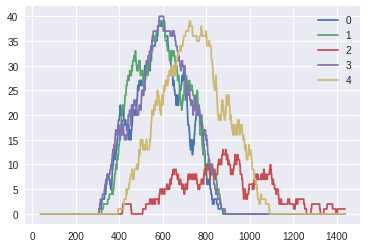

In [22]:
np.random.shuffle(fake_data)
all_data = pd.DataFrame(fake_data)
all_data.head(5).T.rolling(40).sum().plot()


# Build Seq2Seq Model

## hyperparameters

In [0]:

batch_size = 17   # Batch size for training. 85/5 = 17
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = all_data.shape[0]  # Number of samples to train on.

## build the model

Encoder:
1. Input
2. LSTM -> take out the hidden value
